This is my second kernel series contribution to <a href="https://www.kaggle.com/c/ds4g-environmental-insights-explorer/overview"> DS4G: Environmental Insights Explorer </a> to analyze the impacts of air pollution at a particular Geographical area and location

In this kernel, the implementation of Data integration and Pre-processing pipeline is detailed.

<a href="#dataIntegration">**Compenent A - Setup config and Pre-processing pipeline **</a>
*     <a href="#code architecture">Step 1: Code pipeline</a>
*     <a href="#setupConfig">Step 2: Setting up global config</a>
*     <a href="#structureSubNational">Step 3: Structure Sub National region</a>
*     <a href="#convertpowerPlant">Step 4: Convert Power plants from csv file to Geolocation shape file</a>
*     <a href="#septimeseries">Step 5: Separate Sentinel 5P, GFS, GLDAS satelite image by Timeseries</a>

<a href="#componentb">**Compenent B - Emissions / Weather Data Processing**</a>

*     <a href="#powerplantSubregions">Step 1: Separate Power plants by Sub National region</a>
*     <a href="#sepweather">Step 2: Separate Sentinel 5P, GFS, GLDAS by Sub National region</a>
*     <a href="#mergeweather">Step 3: Merge GFS, GLDAS satelite imagery</a>
*     <a href="#calcemissionfactor">Step 4: Calculate Emission Factor</a>
*     <a href="#calcweather">Step 5: Mean Weather caluclation</a>


<p id="dataIntegration" style="color:#703bdb; font-size:20px">Component A : Setup config and Pre-processing pipeline</p>
<hr size="30">

This is the first component of the overall pipeline. In this component, the major focus is on the integrate and process datasets that needs to be used in the complete solution. These datasets are : Sentinel 5P, GFS, GLDAS Satelite image for Puereto Rico region for a time period from July-2018 to June-2019, GPPD provide annual data of power plants, Sub-National region data in shape file.

Following are the key tasks which are executed in this component.

1. Prepare configuration file

2. Integration of data from multiple data sources

3. Creation of Structured Repository

4. Processing of Emission and Weather data     
     3.1 Error handelling <br />
     3.2 Building the data by Time series
          
5. Filtering Emission and weather data to Sub National region

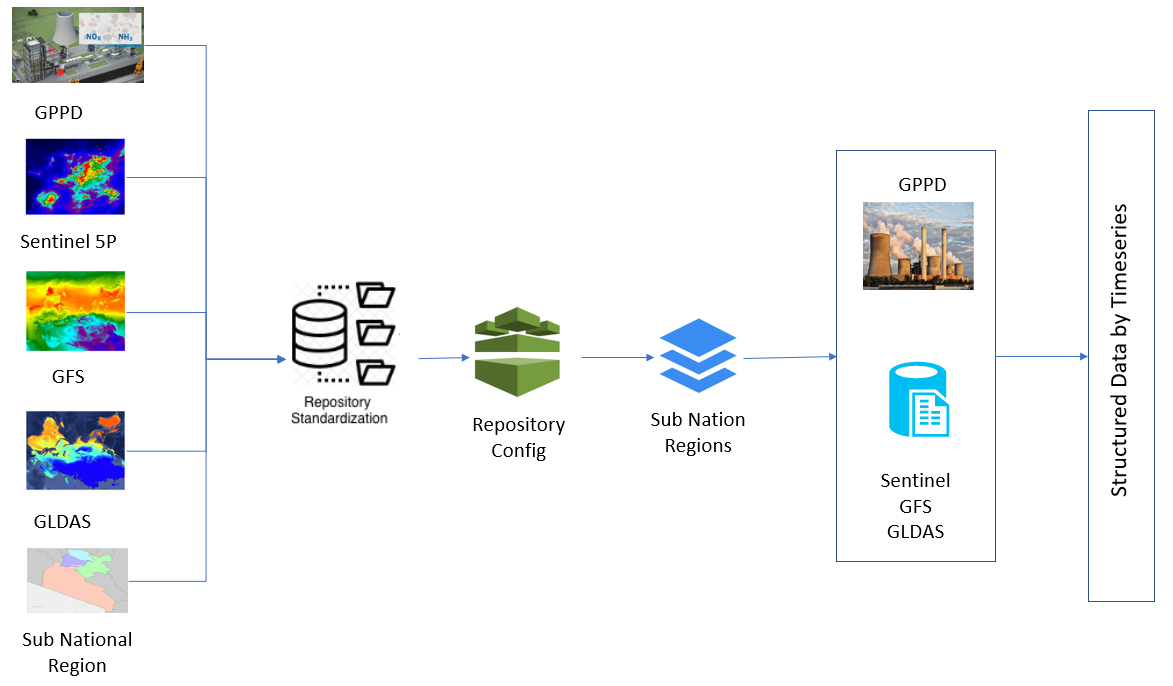

<p id="setupConfig" style="color:#703bdb; font-size:20px">Step 1: Code pipeline</p>
<hr size="30">
During the code development for this challenge, code has been organised in separate class files to make the code dynamic and mostly reusuable. Below are code files added in this challenge. Go through each file for more details of the code

emissionexplorer - main executable script. This script used to create emission model.

emissionprediction - main executable script. This script used to predict emission factor.

emissionanalyzer - Added as a utility script.

emissionconfig - Added as a utility script. 

emissiondataset - Added as a utility script. 

emissionglobals - Added as a utility script.

emissionmarginal - Added as a utility script.

emissionplot - Added as a utility script.

emissionspatial - Added as a utility script.

emissionweather - Added as a utility script.

emissionmodel - Added as a utility script


<p id="setupConfig" style="color:#703bdb; font-size:20px">Step 2: Setting up global config</p>
<hr size="30">
In the first step of the pipeline, we define the important global configurations to be used in the pipeline. This step serves as a configuration defining step, which can be changed again and again by the user with different types or sources of data, raster bands to be considered for analysis, raster bands to be considered for output, adding additional sub nation regions etc., This config acts like a controller to the user through which they can control how they want to execute the pipeline. In this config file, following parameters need to be defined:

**sentinel-5P** node used to hold information of sentinel-5p satelite imagery.

"Type" item details about the purpose of node, here the purpose is emission. This make user to add another emission source just by specifying the type. No dependency on name of node.

"data_Path" item details about location of data source

"concatType" item details how to aggregate data for each date

"file_format" item details how to extract timeseries from file name

"file_name_start_at" & "file_name_start_end" item details the position of date in file name

"gfs" and "gldas" follows the same. Here, it's purpose is to hold weather satelite imagery

**gppd** node used to hold information of Global Power Plant. Specify this type as Generator

data_path item details about location of data source in csv format

For more details of configuration file visit <a href="https://www.kaggle.com/nagabilwanth/step-1-create-a-configuration-file">Configuration details</a>


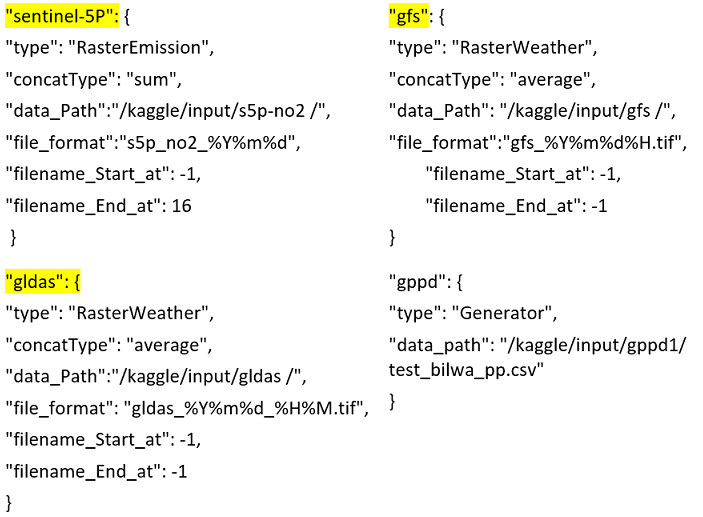

**Code Details**

For this challenge, created a class appConfig that contain support functions to fetch the content of configuration file easily. This class is availble in file emissionconfig.py. This script file uploaded as a utility script to Kaggle to make easily reference as needed.

To use this class follow below steps


In [ ]:
from emissionconfig import appConfig

objConfig = appConfig("/kaggle/input/ds4gconfiguration/config_kaggle.json")
outputPath = "/kaggle/working/output/"

# Get config elements
config = objConfig.getConfig()

emissionconfig class has several functions which was referenced in entire project.

getLayerList -- Get Layers specified in Spatial node in config

getlayerInfo -- Get layer info listed in Spatial node such as projection, rasterReference etc.,

getAllTrainFields -- Get raster bands that need to be considered for Training the Model

getAllPlotFields -- Get all fields that are specified as true in config

getLayerType --  Get Layer Type from the spatial node in config

<p id="structureSubNational" style="color:#703bdb; font-size:20px">Step 3: Structure Sub National region</p>
<hr size="30">
To perform analysis for sub national region, we need spatial boundary of the sub national region of Puerto Rico, intrested in. I downloaded county boundary shape file from below url. The shape file downloaded as county boundaries for entire USA. To filter boundaries of Puerto Rico, I used QGIS tool. Shape file has several fields, hence identified field that provide unique identfier for the polygon and changed column name as "name" in filtered shape file

https://catalog.data.gov/dataset/tiger-line-shapefile-2017-nation-u-s-current-county-and-equivalent-national-shapefile

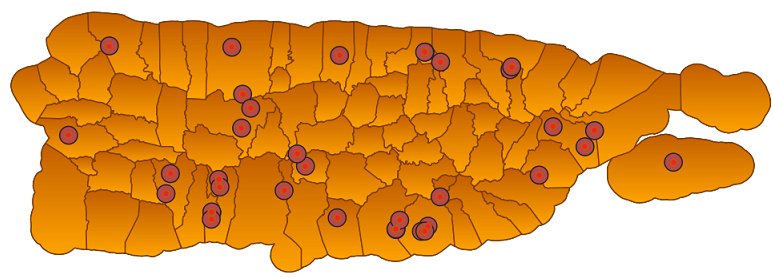

The sub national regions considered to perform analysis can be listed in configuration as below, to make the code dynamic. For the analysis, I considered below sub national regions

1. Region Polygon 
2. County 
3. 100 mile boundary from Power plant
4. 50 mile boundary from Power plant


Considered Sub National regions configured under node "emissionAnalyze". The node as below items

"type" - It represnts node type as spatial
"projection" - It represents the spatial reference used by all sub national region polygons
"rasterReference" - Raster path. It use first raster file in directory to extract the Upper left corner of the raster. This is used to convert raster from world co-ordinates to pixel co-ordinates.

"layers" - List of layers to be considered in analysis
"name" - unique identifier of the layer
"type" - These are two types. Landbase_subregion and powerplant_subregion. Use type Landbase_subregion for            polygon layers and powerplant_subregion for point layer.

"inpath"- shape file path

"outPath" - for polygon layer it's dummy. Just provide same path as input path. For point layer, it's used as output location for buffer.

"displayfield" - the field of in shape file to be considered as display in output plots

"buffer" - This field exist only of point layer. The distance provided in miles will be buffered to perform anaysis.

Currently I have configured 4 layers, you can execute tool with one layer also


For more details of configuration file visit <a href="https://www.kaggle.com/nagabilwanth/step-1-create-a-configuration-file">Configuration details</a>

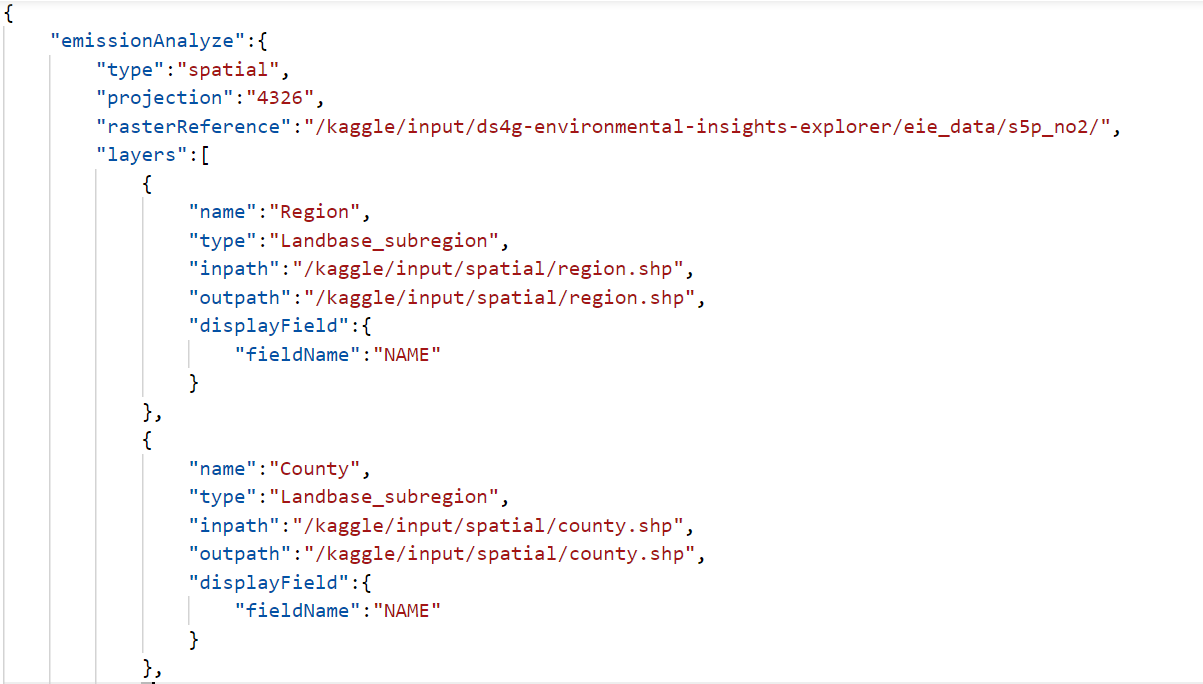

Below code used to convert the provided spatial layer in configuration file as a numpy array.

In [ ]:
from emissionspatial import emissionSpatialLayer
from emissionglobals import appGlobal
from emissionconfig import appConfig

objConfig = appConfig("/kaggle/input/ds4gconfiguration/config_kaggle.json")
outputPath = "/kaggle/working/output/"

aGlobal = appGlobal(objConfig, outputPath)

def getCountySpatialNPArray():
    spl = emissionSpatialLayer(aGlobal, "County")
    dictSubRegions = spl.getSpatialLayerNPArr()


<p id="convertpowerPlant" style="color:#703bdb; font-size:20px">Step 4: Convert Power plants from csv file to Geolocation shape file</p>
<hr size="30">
The provided data for power plants is in csv format. To perform emission analysis, it's required to convert csv file to spatial format so that it can be overlayed on top of sentinel 5p, GFS and GLDAS statelite images. The information for this data source is configured in config as below

For more details of configuration file visit <a href="https://www.kaggle.com/nagabilwanth/step-1-create-a-configuration-file">Configuration details</a> The details for this is listed under GPPD


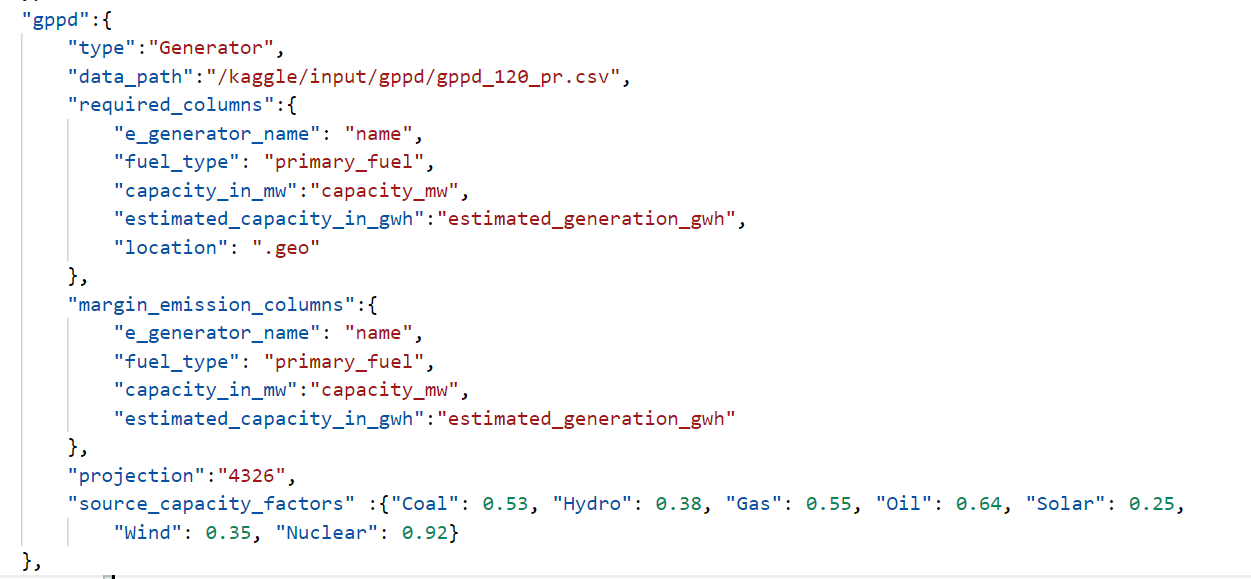

<p id="powerplantSubregions">To get power plants in a provided sub national regional polygon as a data frame use below code.</p>


In [ ]:
from emissionspatial import emissionSpatialLayer
from emissionglobals import appGlobal
from emissionconfig import appConfig

objConfig = appConfig("/kaggle/input/ds4gconfiguration/config_kaggle.json")
outputPath = "/kaggle/working/output/"

aGlobal = appGlobal(objConfig, outputPath)

layerList = objConfig.getLayerList()

def getGeneratorXYLocaiton():
    """
        This method get power plant x,y location as dataframe
    """
    for layer in layerList:
        print('processing layer ' + layer)
        spl = emissionSpatialLayer(aGlobal, layer)    
        dictSubRegions = spl.getSpatialLayerNPArr()

        for subRegion in dictSubRegions:
            # get power plant x,y location as data frame
            dfGeoLocation = spl.getGeneratorXYLocation(subRegion)



<p id="septimeseries" style="color:#703bdb; font-size:20px">Step 5: Separate Sentinel 5P, GFS, GLDAS satelite image by Timeseries</p>
<hr size="30">

The provided data source does not have timeseries information, hence this has been extracted from the file names of Sentinel 5P, GFS, GLDAS satelite images provided. To make this process dynamic, below items added in configuration file under nodes "sentinel-5P", "gfs" and "gldas"

**For Sentinel 5P:**

"file_format":"s5p_no2_%Y%m%d",

"filename_Start_at":-1,

"filename_End_at": 16

**For GLDAS:**

"file_format":"gldas_%Y%m%d_%H%M.tif",

"filename_Start_at":-1,

"filename_End_at": -1,

**For GFS:**

"file_format":"gfs_%Y%m%d%H.tif",     

"filename_Start_at":-1,

"filename_End_at": -1, 

In [ ]:
from emissiondataset import emissionTimeseries

def getDatasetTimeseres(self):
    """
        This method read input rasters names, analyze it and return the given timeseries
        as dataframe
    """
    try:
        dTimeseries = emissionTimeseries(self.objAppConfig, self.rasterType)
        timeseries_df = dTimeseries.getTimeseriesDataFrame()
        return timeseries_df
    except Exception as e:
        print(e)
        print("Failed at emissionanalyzer.py - getDatasetTimeseres")
        

<p id="componentb" style="color:#703bdb; font-size:20px">Compenent B - Emissions / Weather Data Processing</p>
<hr size="30">

In this component, the main focus is on the Emissions and Weather data processing and standardization. The main datasets processed in this component are Sentinel 5P, GFS and GLDAS. Processes such as integrating dataset, calculating emissions, and data enrichment are performed in this step. The final output of this component produces a well structred dataset which is ready for the analysis. Following are the key tasks which are executed in this component.

1. Create a single NUMPY array by integrating Sentinel 5P, GFS and GLDAS
2. Calculate Emission Factor
3. Enrichment of all datasets together to produce a final dataset
4. The dataset created used to perform analysis by Annual, Month-Month and Model Training

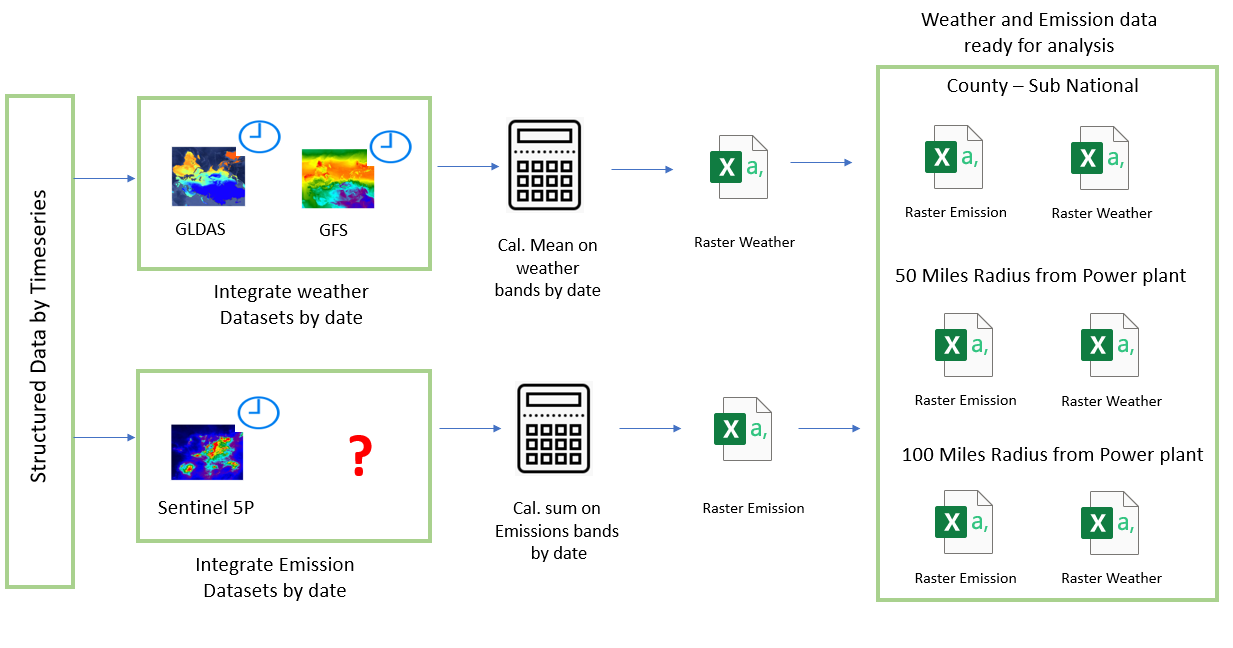

<p id="sepweather" style="color:#703bdb; font-size:20px">Step 2: Separate Sentinel 5P, GFS, GLDAS by Sub National region</p>
<hr size="30">
Separating the raster content to sub region boundary is required to perform deep analysis on emissions.
To achieve this, will be doing below steps inside a method getWeather_subRegion and generateEF_SubRegion

1. Recive the analyze area of sub region as a parameter filled with 0 & 1 in numpy array. 0 represents area should not be considered and 1 represents area should be considered

2. Create a numpy array with the size of the tiff provided 148, 475  and number of band counts specified in config file. To know about, bandsConsidered under Sentinel-5p, GFS, GLDAS  visit <a href="https://www.kaggle.com/nagabilwanth/step-1-create-a-configuration-file">Configuration details</a>

3. Fill all cells of numpy array using analyze area.

4. Get <a href="#septimeseries">timeseries info</a> for given data set

5. Loop through each date

6. While looping through each date, create a new numpy array filled with the raster band information. 

7. Perform clip of raster to sub region by doing multiplication between numpy received in Step 3 and Step 6. 

Below lines of code used to filter the GFS, GLDAS data for a provided Sub National region. 


In [ ]:
from emissionspatial import emissionSpatialLayer
from emissionglobals import appGlobal
from emissionconfig import appConfig

objConfig = appConfig("/kaggle/input/ds4gconfiguration/config_kaggle.json")
outputPath = "/kaggle/working/output/"

aGlobal = appGlobal(objConfig, outputPath)

layerList = objConfig.getLayerList()

def separateweatherRaster():
    """
        This method get power plant x,y location as dataframe
    """
    for layer in layerList:
        print('processing layer ' + layer)
        spl = emissionSpatialLayer(aGlobal, layer)    
        dictSubRegions = spl.getSpatialLayerNPArr()

        for subRegion in dictSubRegions:
            # get power plant x,y location as data frame. This dataframe contain capacity of power plant
            dfGeoLocation = spl.getGeneratorXYLocation(subRegion)
            
            if not dfGeoLocation.empty:
                rpE = emissionFactorAnalyzer(aGlobal, "RasterEmission")
                rpE.generateEF_SubRegion(dictSubRegions[subRegion], dfGeoLocation, subRegion, layer)
                    
                rpW = weatherAnalyzer(aGlobal, "RasterWeather")
                rpW.getWeather_subRegion(dictSubRegions[subRegion], subRegion, layer)

<p id="mergeweather" style="color:#703bdb; font-size:20px">Step 3: Merge GFS, GLDAS satelite imagery</p>
<hr size="30">
   In configuration file, we represented the satelite imagery provided as two types RasterWeather and RasterEmission. GLDAS and GFS come under category RasterWeather and Sentinel 5P come under category RasterEmission. The bands from GLDAS and GFS are filled into a single numpy array. In future, if a requirement come to add new weather satelite imagery for analysis, just add satelite imagery info to configuration file with type RasterWeather. It will be taken care

<p id="calcemissionfactor" style="color:#703bdb; font-size:20px">Step 4: Calculate Emission Factor</p>
<hr size="30">

To calculate emission factor, I have considered two bands provided in Sentinel 5P raster. 

a. NO2_column_number_density - Total vertical column of NO2

b. NO2_slant_column_number_density - NO2 slant column density

Reason to consider only two columns is as below

The TROPOMI NO2 retrieval algorithm is based on the OMI NO2 retrieval algorithm (called DOMINO). This algorithm is a three-step DOAS in which the first (NO2_slant_column_number_density) and third steps (NO2_column_number_density) derive respectively the slant column and the vertical column. These are discussed  <a href="https://earth.esa.int/web/sentinel/technical-guides/sentinel-5p/level-2/doas-method">here</a>.

To see bands considered for Sentinel-5p, visit <a href="https://www.kaggle.com/nagabilwanth/step-1-create-a-configuration-file">Configuration details</a>

If any new band to be added or removed for calculating emission factor, just update the configuration file under bands considered section for Sentinel-5p.

**Steps used to calcualte emission factor**:

This logic is implemented in class emissionanalyzer under method generateEF_SubRegion

* Numpy array received from this <a href="#sepweather">step</a> converted to a single row for each date using a concat type in configuration file. For Sentinel 5P, concat type is sum.

    "sentinel-5P":{
        "type":"RasterEmission",
        "concatType":"sum",

* Fill numpy array in data frame, assign column names to numpy array, using alias name in configuration file
* Perform sum  of two columns NO2_column_number_density + NO2_slant_column_number_density
* estimated capacity of power plant received as input parameter for a specified region. Values in this data frame are annual basis. Convert this value to a single day by dividing with 365

So EF = (NO2_column_number_density + NO2_slant_column_number_density) / (estimated capacity of power plant/365 )

* Dump caluclated data into individual csv file for each sub region

<p id="calcweather" style="color:#703bdb; font-size:20px">Step 5: Mean Weather caluclation</p>
<hr size="30">
The bands considered for weather from satelite images GLDAS and GFS are listed under bands considered. To see this, visit <a href="https://www.kaggle.com/nagabilwanth/step-1-create-a-configuration-file">Configuration details</a>

**Steps used to calcualte emission factor**:

This logic is implemented in class emissionweather under method getWeather_subRegion

* Numpy array received from this <a href="#sepweather">step</a> converted to a single row for each date using a concat type in configuration file. For gfs and gldas, concat type is average.

    "gfs":{
        "type":"RasterWeather",
        "concatType":"average",

* Fill numpy array to data frame, assign column names to numpy array, using alias name in configuration file
* Perform avg caluclation on individual columns for each date
* Dump caluclated data into individual csv file for each sub region



<a href="https://www.kaggle.com/nagabilwanth/3-annual-hist-emissions-for-sub-national-regions" >Next: Part 3: Analysis report for annual historical emissions factor for the sub-national region</a>